# Libraries Used

In [2]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, Dense

ModuleNotFoundError: No module named 'tensorflow'

# Data Importing & Pre-Processing

In [6]:
df = pd.read_csv(r"D:\Aswa\\ChennaiPrice Pro\\Sales - RAW.csv")
df.dropna(inplace=True)

In [7]:
df['DATE_SALE'] = pd.to_datetime(df['DATE_SALE'], format='mixed')
df['DATE_BUILD'] = pd.to_datetime(df['DATE_BUILD'], format='mixed')
df['PROP_AGE'] = pd.DatetimeIndex(df['DATE_SALE'] ).year - pd.DatetimeIndex(df['DATE_BUILD']).year
df.drop(['DATE_SALE','DATE_BUILD'], axis=1, inplace=True)
df["N_BATHROOM"] = df["N_BATHROOM"].astype(int)
df["N_BEDROOM"]=df["N_BEDROOM"].astype(int)
df["QS_BATHROOM"]=df["QS_BATHROOM"].astype(int)
df["QS_BEDROOM"]=df["QS_BEDROOM"].astype(int)
df["QS_OVERALL"]=df["QS_OVERALL"].astype(int)
df["QS_ROOMS"]=df["QS_ROOMS"].astype(int)

In [8]:
df = df.apply(lambda x: x.replace({'Adyr':'Adyar', 'TNagar': 'T Nagar', 'Chrompt': 'Chrompet', 'Chrmpet':'Chrompet', 'Chormpet': 'Chrompet', 'Ann Nagar': 'Anna Nagar',  'Ana Nagar': 'Anna Nagar', 'Velchery': 'Velachery', 'KKNagar': 'KK Nagar', 'Karapakam':'Karapakkam', 'Ab Normal': 'AbNormal', 'Partiall':'Partial', 'PartiaLl': 'Partial', 'AdjLand': 'Adj Land', 'Noo': 'No', 'Comercial':'Commercial', 'Others': 'Other', 'AllPub': 'All Pub', 'NoSewr ':'NoSeWa', 'NoAccess': 'No Access', 'Pavd':'Paved'}, regex=True))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Exploratory Data Analysis on Data

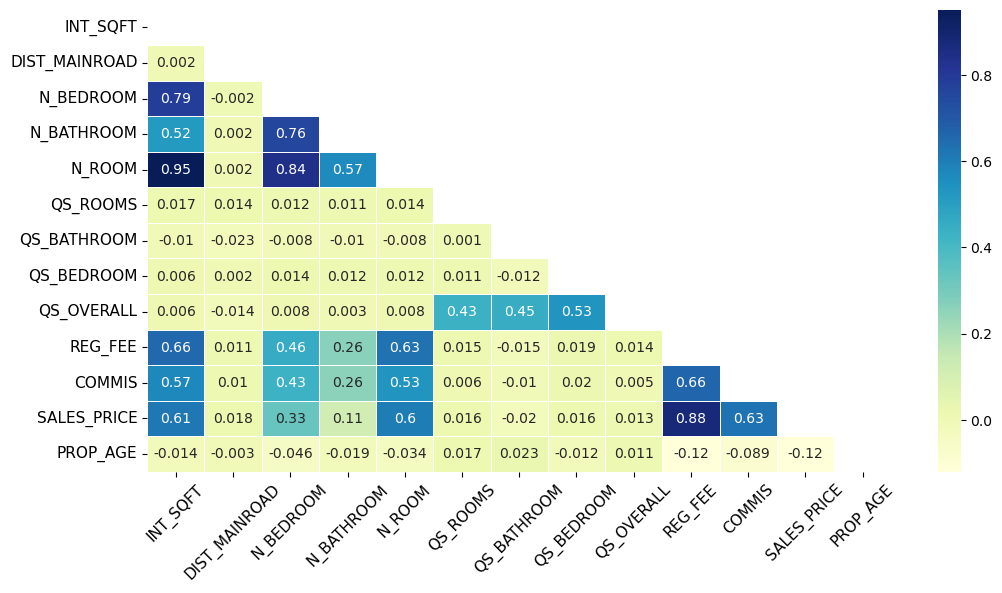

In [55]:
fig1 = plt.figure(figsize=(12,6))
corr = df.drop(["PRT_ID",'AREA','SALE_COND', 'PARK_FACIL', 'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE'], axis=1).corr(method='pearson').round(3)
my_m=np.triu(corr)
sns.heatmap(corr, mask=my_m, annot=True, cmap='YlGnBu', linewidths=0.5, linecolor='white')
plt.xticks(fontsize=11, rotation=45), plt.yticks(fontsize=11)
plt.show()

## Property Age (in Years) vs. Average Sales Price (in Crores)

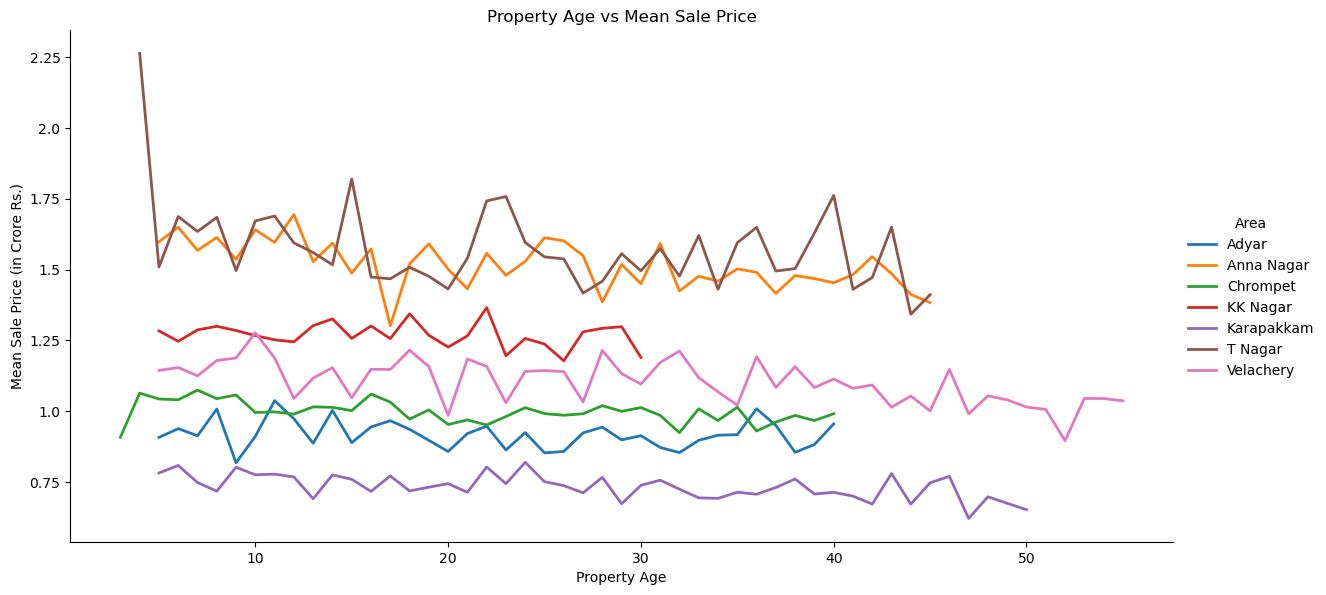

In [56]:
df1 = df.pivot_table(index=['AREA', 'PROP_AGE'], values='SALES_PRICE', aggfunc="mean").reset_index()
fig2 = sns.relplot(kind='line', x='PROP_AGE', y='SALES_PRICE', hue='AREA', data=df1, height=6, aspect=2, palette='tab10', linewidth=2)
plt.xlabel("Property Age")
plt.ylabel("Mean Sale Price (in Crore Rs.)")
plt.title("Property Age vs Mean Sale Price")
plt.yticks(np.linspace(7500000, 22500000, 7),[0.75, 1.0, 1.25, 1.50, 1.75, 2.0, 2.25])
fig2._legend.set_title("Area") 
plt.show()

# Property Sale Prices by Geographic Area

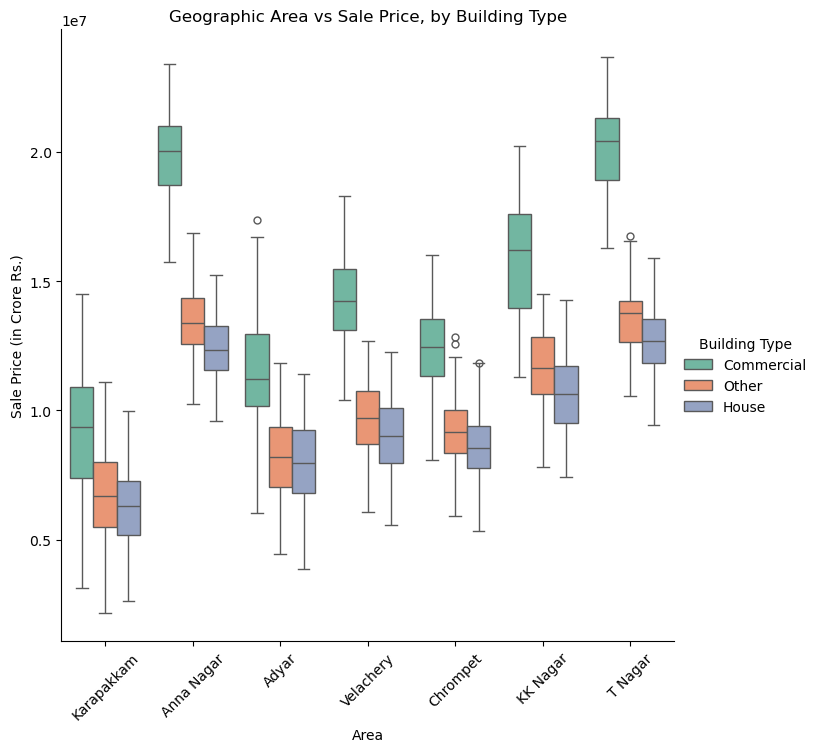

In [57]:
#plt.figure(figsize=(8,8))
fig3= sns.catplot(kind='box',data=df, x="AREA", y="SALES_PRICE", hue="BUILDTYPE", palette='Set2', height=7, aspect=1)
plt.xlabel("Area")
plt.xticks(rotation=45)
plt.ylabel("Sale Price (in Crore Rs.)")
plt.title("Geographic Area vs Sale Price, by Building Type")
fig3._legend.set_title("Building Type") 
plt.show()

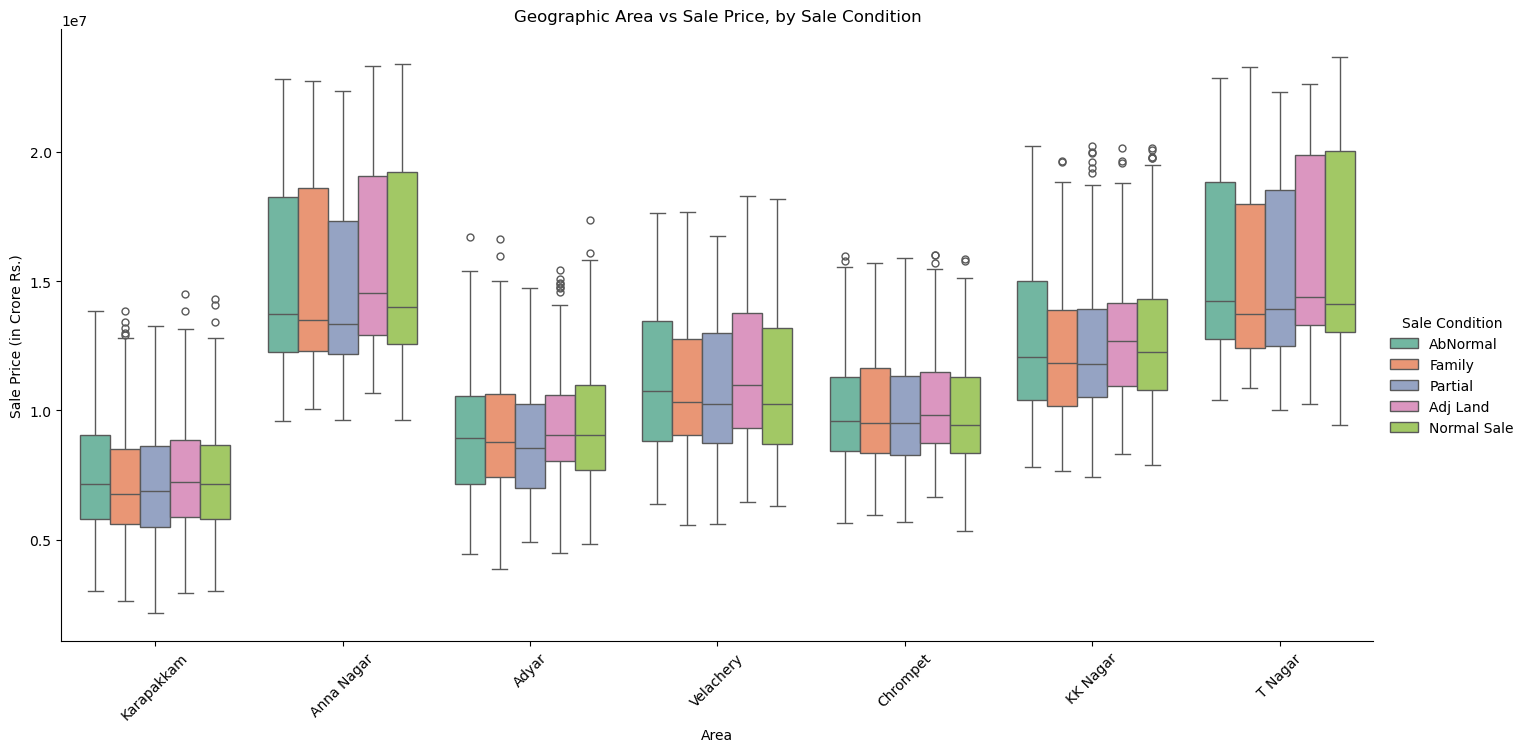

In [58]:
fig4 = sns.catplot(kind='box', data=df, x="AREA", y="SALES_PRICE", hue="SALE_COND", palette='Set2', height=7, aspect=2)
plt.xlabel("Area")
plt.xticks(rotation=45)
plt.ylabel("Sale Price (in Crore Rs.)")
plt.title("Geographic Area vs Sale Price, by Sale Condition")
fig4._legend.set_title("Sale Condition") 
plt.show()

# Sales Sample Count by Geographic Area

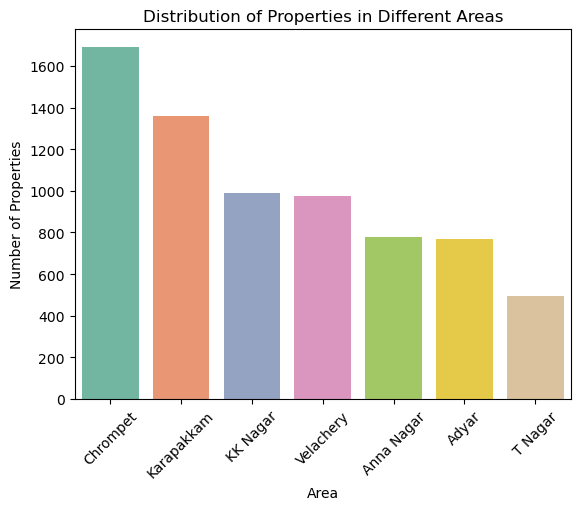

In [59]:
fig5 = sns.countplot(x='AREA', data=df, order=df['AREA'].value_counts().index, palette='Set2')
plt.title("Distribution of Properties in Different Areas")
plt.xlabel("Area")
plt.ylabel("Number of Properties")
plt.xticks(rotation=45)
plt.show()

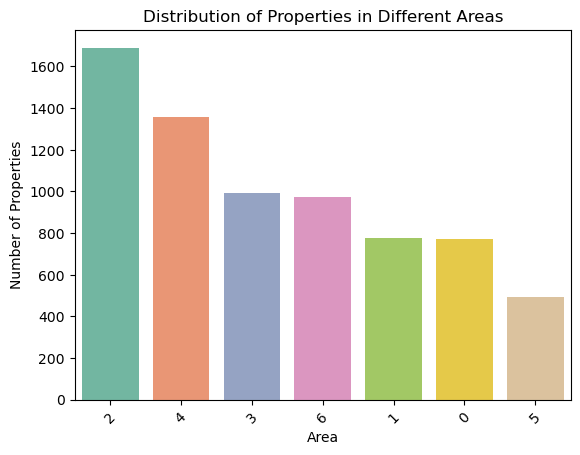

In [12]:
fig5 = sns.countplot(x='AREA', data=numdf, order=numdf['AREA'].value_counts().index, palette='Set2')
plt.title("Distribution of Properties in Different Areas")
plt.xlabel("Area")
plt.ylabel("Number of Properties")
plt.xticks(rotation=45)
plt.show()

# Distribution of Building Types by Geographic Area

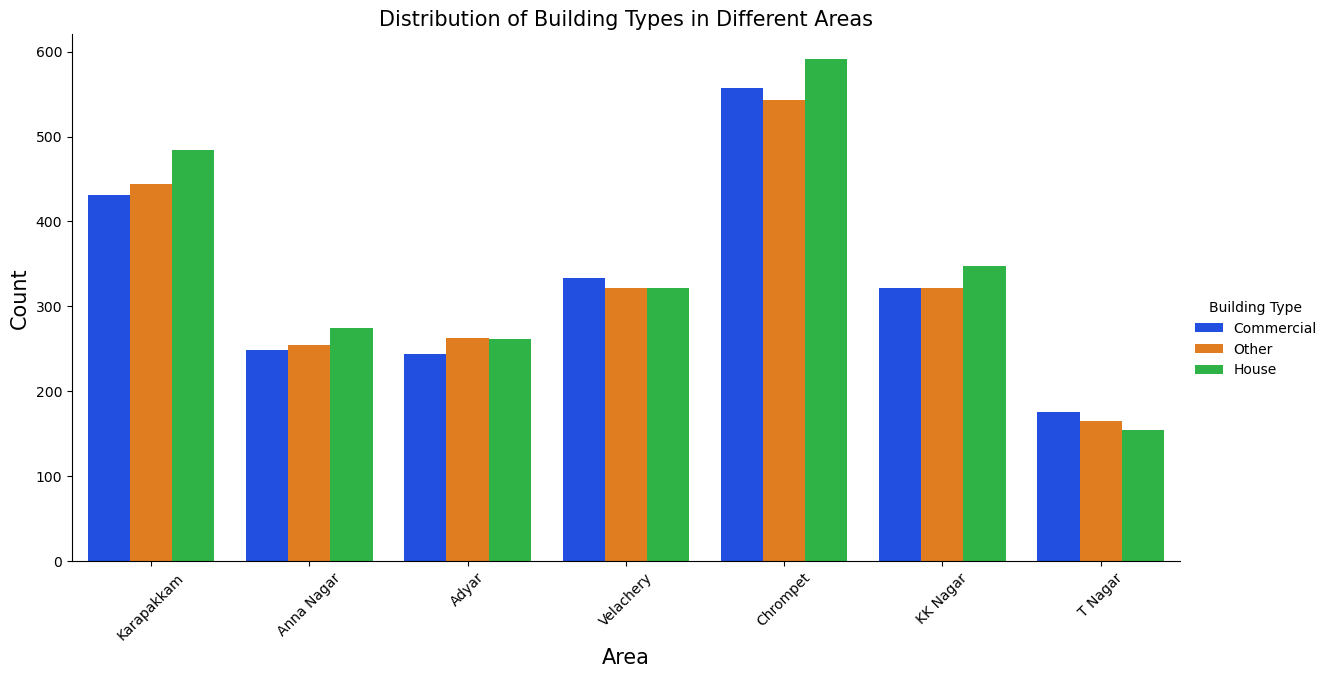

In [60]:
fig6 = sns.catplot(kind='count', x='AREA', hue='BUILDTYPE', data=df, palette='bright', height=6, aspect=2)
plt.title("Distribution of Building Types in Different Areas", fontsize=15)
plt.xlabel("Area", fontsize=15)
plt.ylabel("Count", fontsize=15)
fig6._legend.set_title("Building Type") 
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Segment Share Analysis

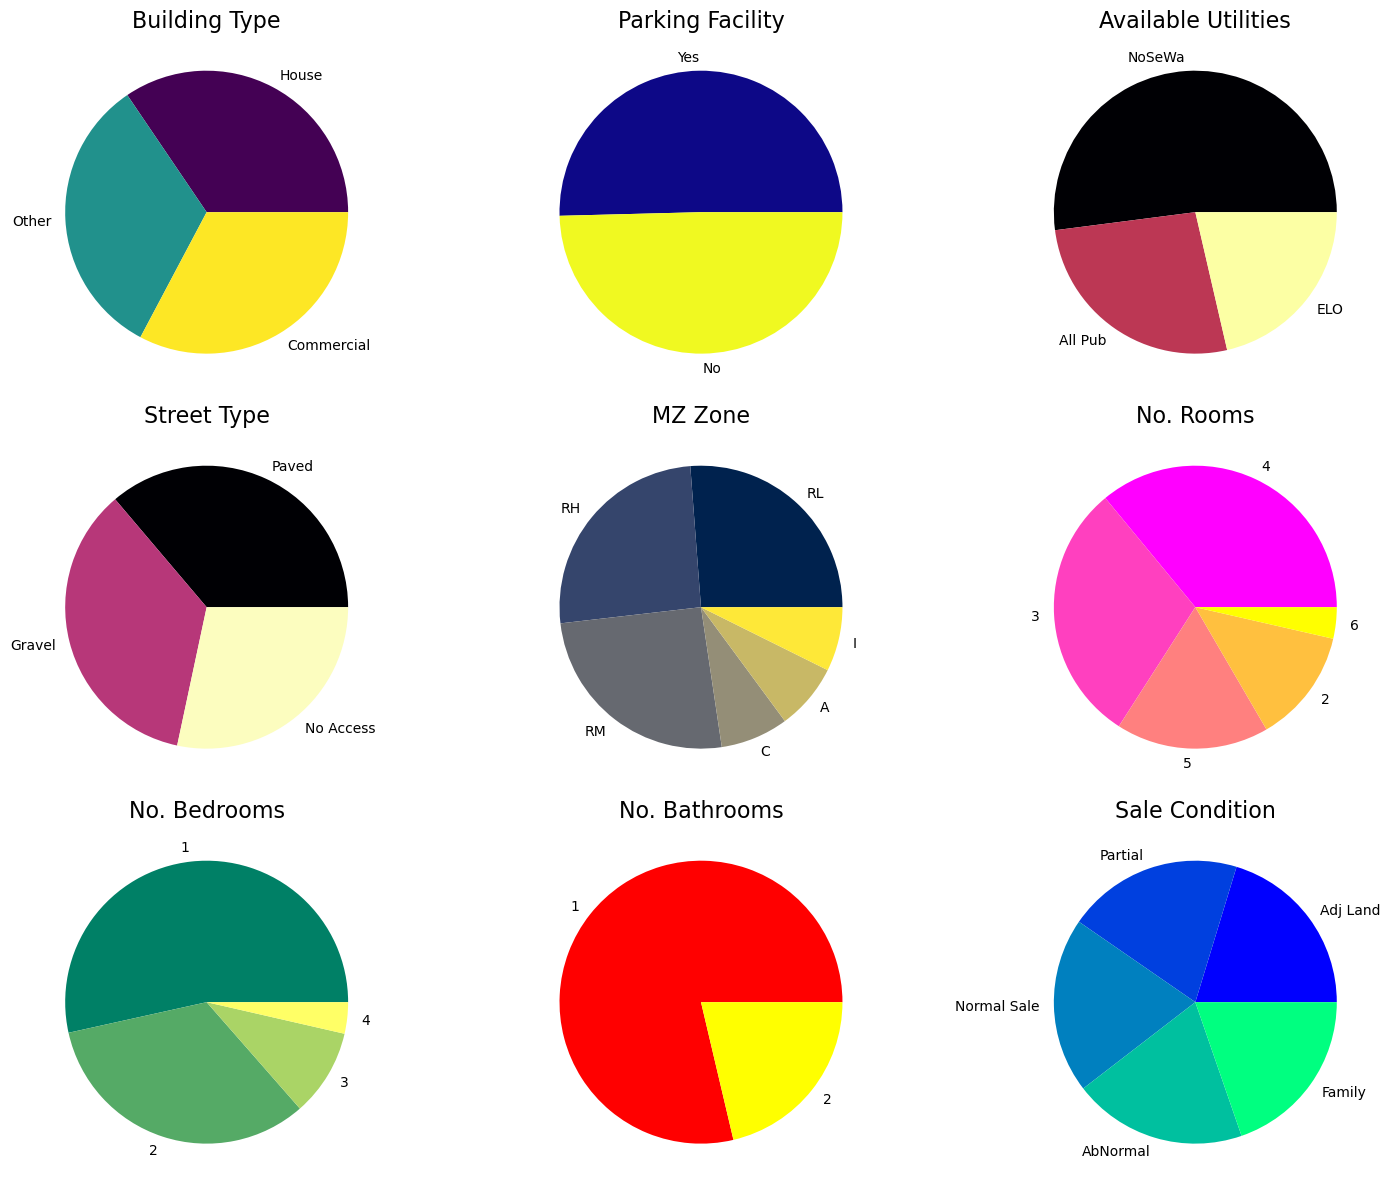

In [9]:
plt.figure(figsize=(15, 12))

titles = [
    'Building Type', 'Parking Facility', 'Available Utilities', 'Street Type', 
    'MZ Zone', 'No. Rooms', 'No. Bedrooms', 'No. Bathrooms', 'Sale Condition'
]
columns = [
    'BUILDTYPE', 'PARK_FACIL', 'UTILITY_AVAIL', 'STREET', 
    'MZZONE', 'N_ROOM', 'N_BEDROOM', 'N_BATHROOM', 'SALE_COND'
]
colormaps = [
    'viridis', 'plasma', 'inferno', 'magma', 
    'cividis', 'spring', 'summer', 'autumn', 'winter'
]
for i, (title, col, cmap) in enumerate(zip(titles, columns, colormaps), 1):
    plt.subplot(3, 3, i)
    plt.title(title, fontsize=16)
    df[col].value_counts().plot(
        kind='pie', fontsize=10, legend=None, ylabel='', colormap=cmap
    )

plt.tight_layout()
plt.show()

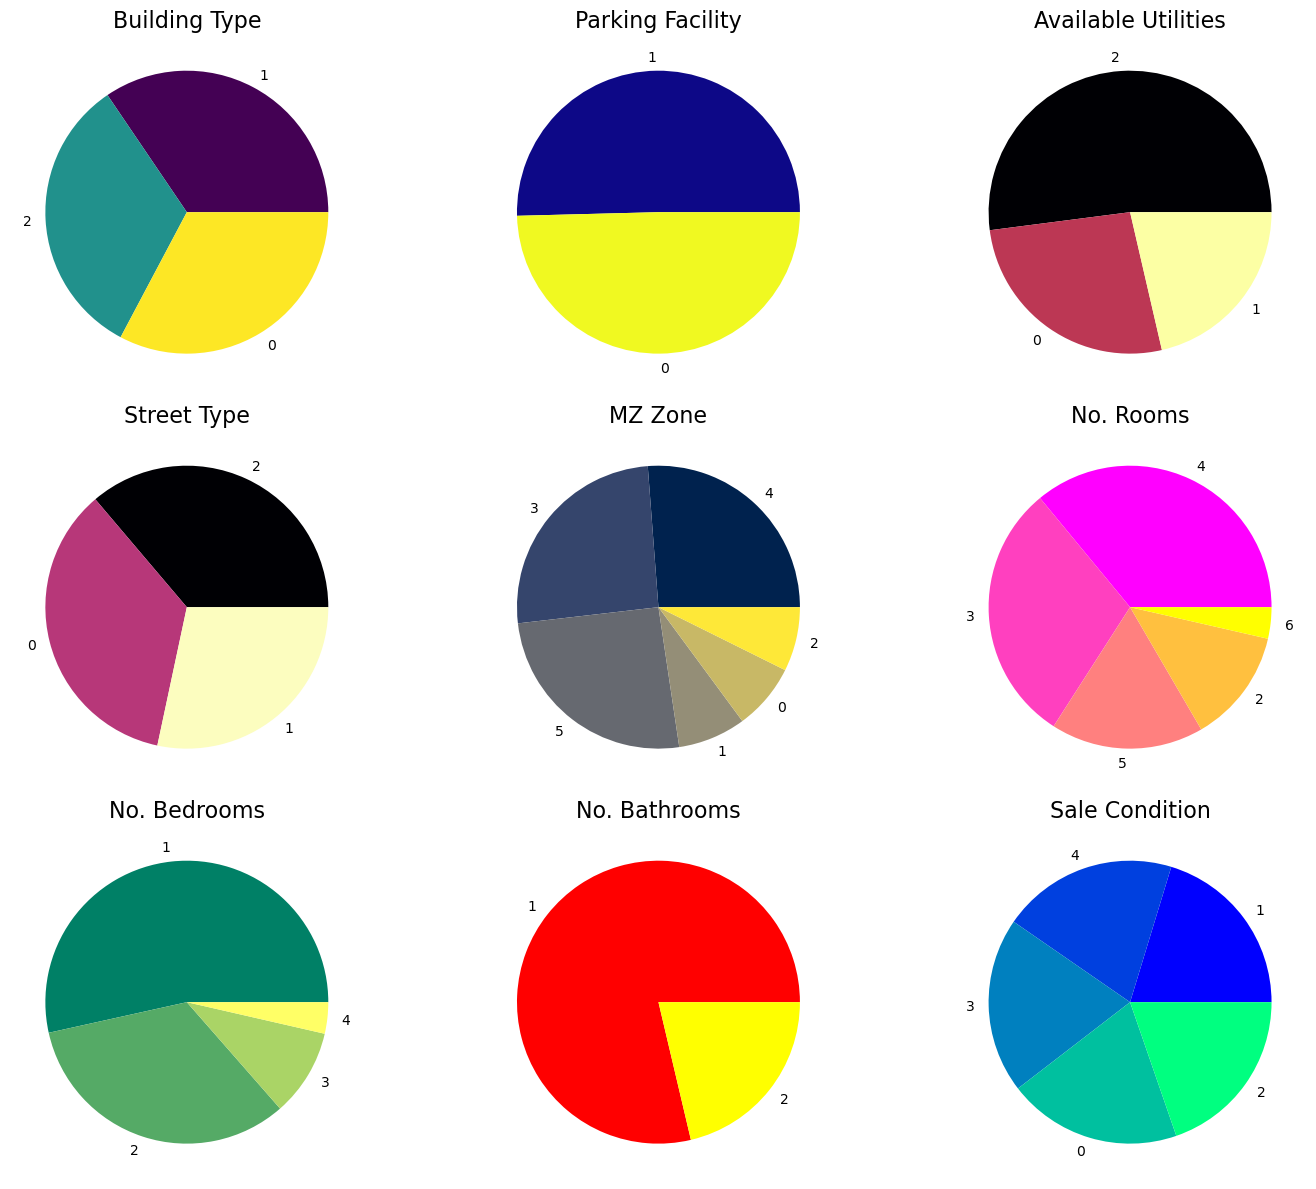

In [11]:
plt.figure(figsize=(15, 12))

titles = [
    'Building Type', 'Parking Facility', 'Available Utilities', 'Street Type', 
    'MZ Zone', 'No. Rooms', 'No. Bedrooms', 'No. Bathrooms', 'Sale Condition'
]
columns = [
    'BUILDTYPE', 'PARK_FACIL', 'UTILITY_AVAIL', 'STREET', 
    'MZZONE', 'N_ROOM', 'N_BEDROOM', 'N_BATHROOM', 'SALE_COND'
]
colormaps = [
    'viridis', 'plasma', 'inferno', 'magma', 
    'cividis', 'spring', 'summer', 'autumn', 'winter'
]
for i, (title, col, cmap) in enumerate(zip(titles, columns, colormaps), 1):
    plt.subplot(3, 3, i)
    plt.title(title, fontsize=16)
    numdf[col].value_counts().plot(
        kind='pie', fontsize=10, legend=None, ylabel='', colormap=cmap
    )

plt.tight_layout()
plt.show()

# Scatter Plots (Sale Price vs Sq. ft area, Registration fee, & commission)

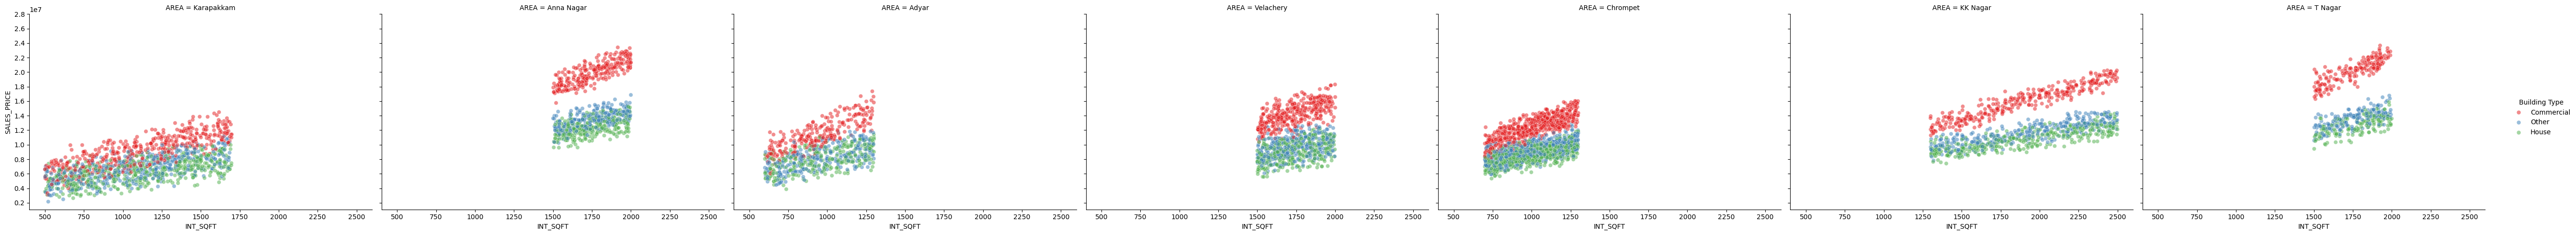

In [62]:
fig7 = sns.relplot(kind='scatter', x='INT_SQFT', y='SALES_PRICE', col="AREA", hue='BUILDTYPE', data=df, alpha=0.5, height=5, aspect=1.5, palette='Set1')
plt.yticks(np.arange(2000000, 30000000, 2000000))
for ax in fig6.axes.flatten():
    ax.set_xlabel("Area (in Sq.Ft)")
    ax.set_ylabel("Sale Price (in Crore Rs.)")
fig7._legend.set_title("Building Type") 
plt.show()

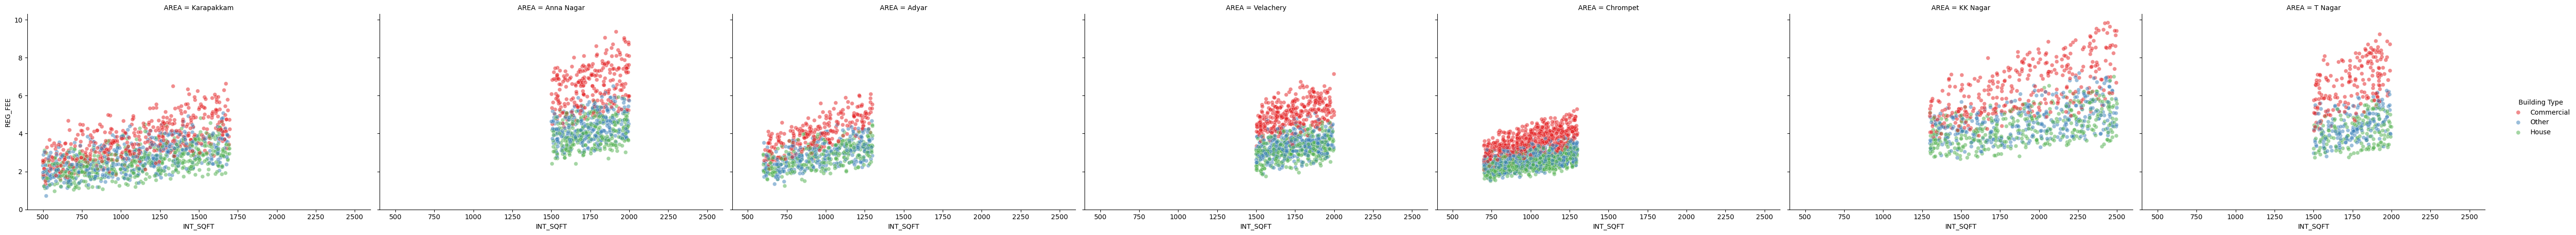

In [63]:
fig8 = sns.relplot(kind='scatter', x='INT_SQFT', y='REG_FEE', col="AREA", hue='BUILDTYPE', data=df, alpha=0.5, height=5, aspect=1.5, palette='Set1')
plt.yticks([0, 200000, 400000 ,600000, 800000, 1000000], [0, 2, 4, 6, 8, 10])
for ax in fig7.axes.flatten():
    ax.set_xlabel("Area (in Sq.Ft)")
    ax.set_ylabel("Registration Fees (in Lakh Rs.)")
fig8._legend.set_title("Building Type") 
plt.show()

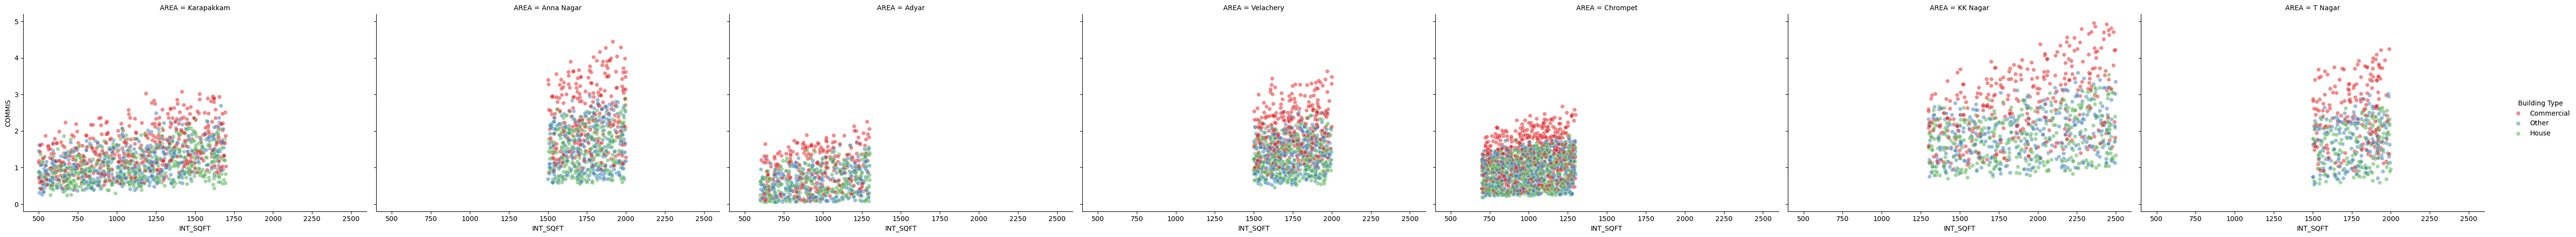

In [64]:
fig9 = sns.relplot(kind='scatter', x='INT_SQFT', y='COMMIS', col="AREA", hue='BUILDTYPE', data=df, alpha=0.5, height=5, aspect=1.5, palette='Set1')
plt.yticks([0, 100000, 200000, 300000, 400000, 500000], [0, 1, 2, 3, 4, 5])
for ax in fig8.axes.flatten():
    ax.set_xlabel("Area (in Sq.Ft)")
    ax.set_ylabel("Commission (in Lakh Rs.)")
fig9._legend.set_title("Building Type") 
plt.show()

# Pre-Processing the Data for Modelling

In [10]:
numdf = df.copy()
le = LabelEncoder()
for col in numdf.columns:
  if numdf[col].dtype == 'object':
    numdf[col] = le.fit_transform(df[col])

In [13]:
X = numdf.drop(['PRT_ID', 'REG_FEE', 'SALES_PRICE', 'COMMIS'], axis=1)
y = numdf['SALES_PRICE']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
print(X_train.shape)

(4939, 17)


# Prreliminary Model Selection & Evaluation

In [68]:
models = [LinearRegression(), Lasso(alpha=0.2),DecisionTreeRegressor(random_state=42)]
for model in models:
  inst = model
  inst.fit(X_train, y_train)
  yPred = inst.predict(X_test)
  print(str(inst))
  print(f'MSE: {mean_squared_error(y_test ,inst.predict(X_test))}')
  print(f'MAE: {mean_absolute_error(y_test ,inst.predict(X_test))}')
  print(f'R2 Score: {r2_score(y_test ,inst.predict(X_test))}')
  print()

LinearRegression()
MSE: 3021757285125.5264
MAE: 1419286.053003248
R2 Score: 0.7905475285618926

Lasso(alpha=0.2)
MSE: 3021757274545.762
MAE: 1419285.9305279038
R2 Score: 0.7905475292952268

DecisionTreeRegressor(random_state=42)
MSE: 632558106074.6339
MAE: 617524.7520075579
R2 Score: 0.9561543677588795



# Testing Ensemble Methods

In [69]:
RFRegressor = RandomForestRegressor(random_state=42)
RFRegressor.fit(X_train, y_train)
print(f'MSE: {mean_squared_error(y_test ,RFRegressor.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test ,RFRegressor.predict(X_test))}')
print(f'R2 Score: {r2_score(y_test ,RFRegressor.predict(X_test))}')

MSE: 285142733263.60724
MAE: 411887.0473547473
R2 Score: 0.9802353913437496


In [70]:
BoosterModel = GradientBoostingRegressor(random_state=42)
BoosterModel.fit(X_train, y_train)
print(f'MSE: {mean_squared_error(y_test ,BoosterModel.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test ,BoosterModel.predict(X_test))}')
print(f'R2 Score: {r2_score(y_test ,BoosterModel.predict(X_test))}')

MSE: 230403941543.86694
MAE: 351169.8461833338
R2 Score: 0.9840295991928288


In [71]:
ExtremeBooster = XGBRegressor(random_state=42, device='cuda')
ExtremeBooster.fit(X_train, y_train)
print(f'MSE: {mean_squared_error(y_test ,ExtremeBooster.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test ,ExtremeBooster.predict(X_test))}')
print(f'R2 Score: {r2_score(y_test ,ExtremeBooster.predict(X_test))}')

MSE: 78522174239.28333


C:\Users\Arkhins\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:13:36] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


MAE: 214302.06105337743
R2 Score: 0.99455726146698


# Refining GradientBoostingRegressor & XGBRegressor

In [72]:
params = {
    'GradientBoostingRegressor':{
        'model' : GradientBoostingRegressor(),
        'params' : {
            'n_estimators' : [100, 200, 300],
            'criterion' : ['squared_error'],
            'loss' : ['squared_error'],
            'max_depth' : [5, 7, 9],
            'min_samples_leaf' : [0.1, 0.3, 0.5],
            'learning_rate' : [0.05, 0.1, 0.2]
        }
    },
    'XGBRegressor':{
        'model' : XGBRegressor(),
        'params' : {
            'n_estimators' : [1000, 2000],
            'max_depth' : [3, 4],
            'learning_rate' : [0.1, 0.2],
            'reg_lambda' : [0.01, 0.1],
            'subsample': [0.8, 0.9]
        }
    }
}

In [73]:
for model_name, model_info in params.items():
    print(f"Starting grid search for {model_name}...")
    
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        scoring='neg_mean_squared_error',
        cv=3)
    
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")

Starting grid search for GradientBoostingRegressor...
Best parameters for GradientBoostingRegressor: {'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 0.1, 'n_estimators': 300}
Best score for GradientBoostingRegressor: -129484800862.55354
Starting grid search for XGBRegressor...
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 2000, 'reg_lambda': 0.1, 'subsample': 0.9}
Best score for XGBRegressor: -22151557552.526608


In [74]:
OptimizedBooster = GradientBoostingRegressor(
    criterion = 'squared_error',
    learning_rate = 0.2,
    loss = 'squared_error',
    max_depth = 7,
    min_samples_leaf = 0.1,
    n_estimators = 800,
    random_state=42
)
OptimizedBooster.fit(X_train, y_train)
print(f'MSE: {mean_squared_error(y_test ,OptimizedBooster.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test ,OptimizedBooster.predict(X_test))}')
print(f'R2 Score: {r2_score(y_test ,OptimizedBooster.predict(X_test))}')

MSE: 91978535594.87527
MAE: 212010.96646478018
R2 Score: 0.9936245271271665


In [75]:
OptimizedXGBooster = XGBRegressor(
    objective = 'reg:squarederror',
    learning_rate = 0.1,
    max_depth = 3,
    n_estimators = 2000,
    reg_lambda = 0.1,
    reg_alpha=0.3,
    subsample = 0.9,
    colsample_bytree = 0.5,
    colsample_bylevel = 0.95,
    random_state = 42,
    device='cuda'
)
OptimizedXGBooster.fit(X_train, y_train)
print(f'MSE: {mean_squared_error(y_test ,OptimizedXGBooster.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test ,OptimizedXGBooster.predict(X_test))}')
print(f'R2 Score: {r2_score(y_test ,OptimizedXGBooster.predict(X_test))}')

C:\Users\Arkhins\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:58] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


MSE: 15875856327.188238
MAE: 95683.55007085498
R2 Score: 0.9988995790481567


# Implementing Dense Neural Networks

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
model = Sequential()

model.add(Input(shape=(X_train_scaled.shape[1],)))
model.add(Dense(512, activation='selu'))
model.add(Dense(128, activation='selu'))
model.add(Dense(64, activation='selu'))
model.add(Dense(1, activation='relu'))  

In [78]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,201 (325.00 KB)

 Trainable params: 83,201 (325.00 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
model.compile(optimizer=Adam(learning_rate=0.2, amsgrad=True, use_ema=True), loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 45630814683136.0000 - mean_absolute_error: 4811427.0000 - val_loss: 2342233833472.0000 - val_mean_absolute_error: 1164950.7500
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1403825160192.0000 - mean_absolute_error: 924410.6250 - val_loss: 593080221696.0000 - val_mean_absolute_error: 606872.1875
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 634768195584.0000 - mean_absolute_error: 634808.5625 - val_loss: 506502545408.0000 - val_mean_absolute_error: 545521.3750
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 438732029952.0000 - mean_absolute_error: 520307.3750 - val_loss: 392295940096.0000 - val_mean_absolute_error: 485757.2812
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 389616173056.0000 - mean_absolute_error: 479710.1250 - val_loss: 548295114752.0000 - val_mean_absolute_error: 604482.2500
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 353004617728.0000 

In [80]:
print(f'MSE: {mean_squared_error(y_test ,model.predict(X_test_scaled))}')
print(f'MAE: {mean_absolute_error(y_test ,model.predict(X_test_scaled))}')
print(f'R2 Score: {r2_score(y_test ,model.predict(X_test_scaled))}')

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 7914973444.67454
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 69251.00708549835
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R2 Score: 0.9994513988494873


# Model Object Generation

In [81]:
OptimizedXGBooster.save_model("xgboost_model.json")
model.save("neural_network_model.keras")

# Conclusions

In [87]:
model_scores = {
    'Model': ['Linear', 'Lasso', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Extreme Gradient Boosting', 'Opt. GB', 'Opt. XGB', 'Dense Network'],
    'MAE': [1419286, 1419285, 617524, 411498, 351169, 214302, 212010, 95683, 69251],
    'R2 Score': [79.05, 79.05, 95.61, 98.04, 98.40, 99.50, 99.36, 99.88, 99.96]
}

scores_df = pd.DataFrame(model_scores)

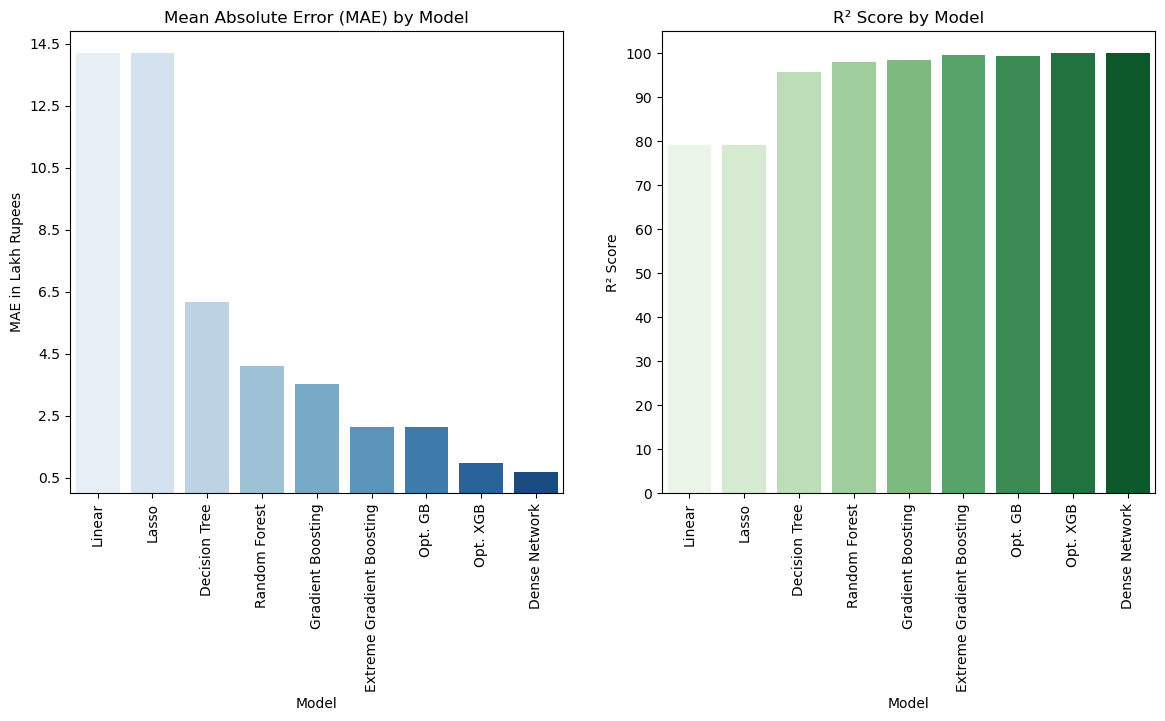

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=scores_df, x='Model', y='MAE', ax=axes[0], palette='Blues')
axes[0].set_title('Mean Absolute Error (MAE) by Model')
axes[0].set_ylabel('MAE in Lakh Rupees')
axes[0].set_xlabel('Model')
axes[0].set_yticks(np.arange(50000, 1500000, 200000), [0.5, 2.5, 4.5, 6.5, 8.5, 10.5, 12.5, 14.5])
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(data=scores_df, x='Model', y='R2 Score', ax=axes[1], palette='Greens')
axes[1].set_title('R² Score by Model')
axes[1].set_ylabel('R² Score')
axes[1].set_xlabel('Model')
axes[1].set_yticks(np.arange(0, 101, 10))
axes[1].tick_params(axis='x', rotation=90)

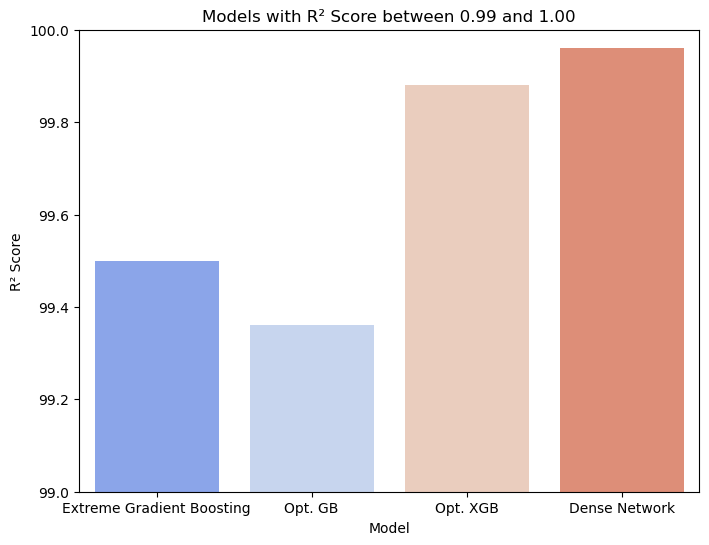

In [89]:
filter_df = scores_df[scores_df['R2 Score'] > 99]
plt.figure(figsize=(8, 6))
sns.barplot(data=filter_df, x='Model', y='R2 Score', palette='coolwarm')
plt.title('Models with R² Score between 0.99 and 1.00')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.ylim(99, 100)
plt.show()

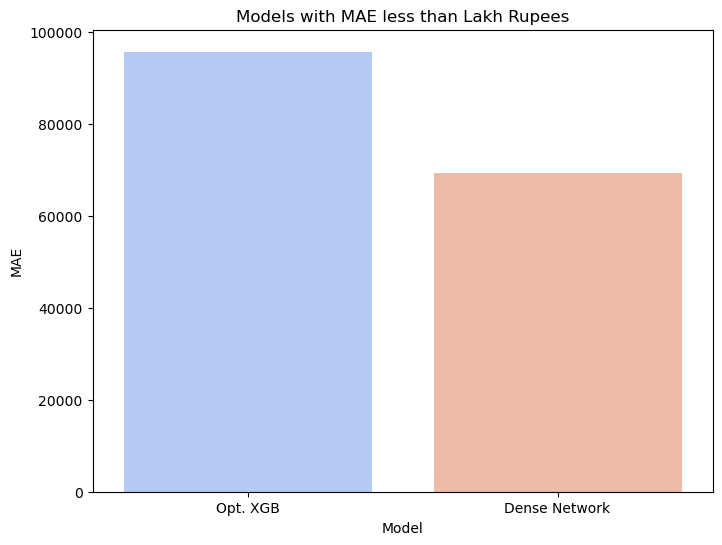

In [90]:
mae_filter_df = scores_df[scores_df['MAE'] < 100000]
plt.figure(figsize=(8, 6))
sns.barplot(data=mae_filter_df, x='Model', y='MAE', palette='coolwarm')
plt.title('Models with MAE less than Lakh Rupees')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.show()

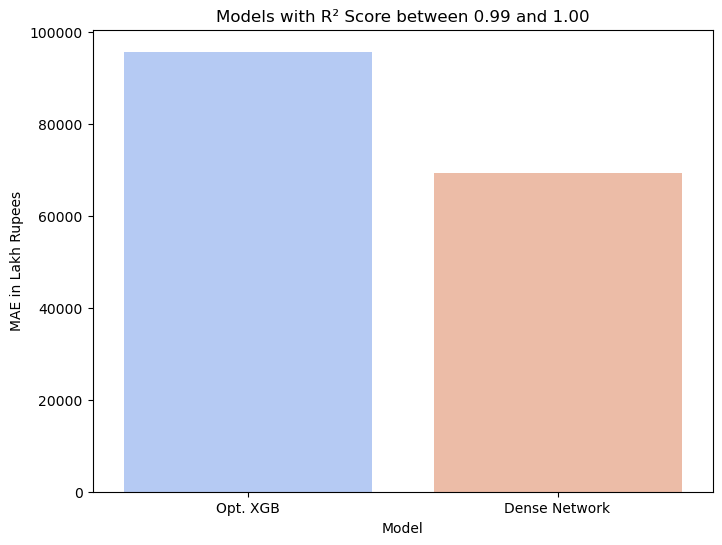

In [91]:
mae_filter_df = scores_df[scores_df['MAE'] < 100000]
plt.figure(figsize=(8, 6))
sns.barplot(data=mae_filter_df, x='Model', y='MAE', palette='coolwarm')
plt.title('Models with R² Score between 0.99 and 1.00')
plt.ylabel('MAE in Lakh Rupees')
plt.xlabel('Model')
plt.show()